In [27]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

# 构建训练网络
class Net(nn.Module):
    def __init__(self, n_states, n_hiddens, n_actions):
        super(Net, self).__init__()
        # 隐藏层为一层
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_actions)
    # 前向传播
    def forward(self, x):
        x = self.fc1(x) # [b, states] ==> [b, n_hiddens]
        x = F.relu(x)
        x = self.fc2(x) # [b, n_hiddens] ==> [b, n_actions]
        # 对batch中每一行样本计算softmax，q值越大，概率越大
        x = F.softmax(x, dim=1)
        return x
    
# 强化学习模型
class PolicyGradient:
    def __init__(self, n_states, n_hiddens, n_actions, learning_rate, gamma):
        # 属性分配
        self.n_states = n_states # 状态数
        self.n_hiddens = n_hiddens # 隐藏层神经元数
        self.n_actions = n_actions # 动作数
        self.learning_rate = learning_rate # 衰减
        self.gamma = gamma # 折扣因子
        self._build_net() # 构建网络模型

    # 网络构建
    def _build_net(self):
        self.policy_net = Net(self.n_states, self.n_hiddens, self.n_actions)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    # 动作选择，根据概率分布随机采样
    def take_action(self, state):
        state = torch.Tensor(state[np.newaxis, :]) # numpy[n_states] ==> [1,n_states] ==> tensor
        # 获取每个人的各动作对应的概率
        probs =self.policy_net(state) # [1,n_states]-->[1,n_actions]
        # 创建以probs为标准类型的数据分布
        action_dist = torch.distributions.Categorical(probs)
        # 以该概率分布随机抽样
        action = action_dist.sample() # [1,n_actions] ==> [1]
        # 将tensor数据变成一个数 int
        action = action.item()
        return action
    
    # 获取每个状态最大的state_value
    def max_q_value(self, state):
        # 维度变换 
        state = torch.tensor(state, dtype=torch.float).view(1, -1) # [n_states] ==> [1,n_states]
        # 获取状态对应的每个动作的reward的最大值
        max_q = self.policy_net(state).max().item() # [1,n_states] ==> [1,n_actions] ==> [1] ==> float
        return max_q
    
    # 训练模型
    def learn(self, transitions_dict): # 输入batch组状态[b,n_states]
        # 取出该回合中所有的链信息
        state_list = transitions_dict['states']
        action_list = transitions_dict['actions']
        reward_list = transitions_dict['rewards']

        G = 0 # 记录该条链的return
        self.optimizer.zero_grad() # 优化器清零
        # 梯度上升最大化目标函数
        for i in reversed(range(len(reward_list))): # 从最后一个reward开始
            # 获取每一步的reward
            reward = reward_list[i] # float
            # 获取每一步的状态 
            state = torch.tensor(state_list[i], dtype=torch.float).view(1, -1) # [n_states] ==> [1,n_states]
            # 获取每一步的动作 
            action = torch.tensor(action_list[i]).view(-1, 1) # [1] ==> [1,1]
            # 当前状态下的各个动作价值函数
            q_value = self.policy_net(state) # [1,2]
            # 获取已action对应的概率 
            log_prob = torch.log(q_value.gather(1, action)) # [1,1]
            # 计算当前状态的state_value = 及时奖励 + 下一时刻的state_value
            G = reward + self.gamma * G
            # 计算每一步的损失函数
            loss = -log_prob * G
            # 反向传播
            loss.backward()
        # 梯度下降
        self.optimizer.step()


In [35]:
len(transition_dict['rewards'])

29

/cpfs01/shared/public/phenix/miniconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


iter:0, return:48.0
iter:1, return:30.0
iter:2, return:25.0
iter:3, return:30.25
iter:4, return:32.8
iter:5, return:37.166666666666664
iter:6, return:33.57142857142857
iter:7, return:31.125
iter:8, return:29.0
iter:9, return:28.6
iter:10, return:29.3
iter:11, return:29.3
iter:12, return:31.8
iter:13, return:29.0
iter:14, return:25.8
iter:15, return:22.8
iter:16, return:24.8
iter:17, return:25.1
iter:18, return:26.4
iter:19, return:29.2
iter:20, return:25.8
iter:21, return:25.5
iter:22, return:22.9
iter:23, return:23.3
iter:24, return:24.5
iter:25, return:23.3
iter:26, return:24.3
iter:27, return:23.9
iter:28, return:23.1
iter:29, return:22.4
iter:30, return:25.8
iter:31, return:26.7
iter:32, return:28.4
iter:33, return:30.7
iter:34, return:29.9
iter:35, return:31.6
iter:36, return:28.6
iter:37, return:30.4
iter:38, return:30.4
iter:39, return:27.7
iter:40, return:23.7
iter:41, return:23.7
iter:42, return:23.5
iter:43, return:21.4
iter:44, return:23.0
iter:45, return:26.7
iter:46, retur

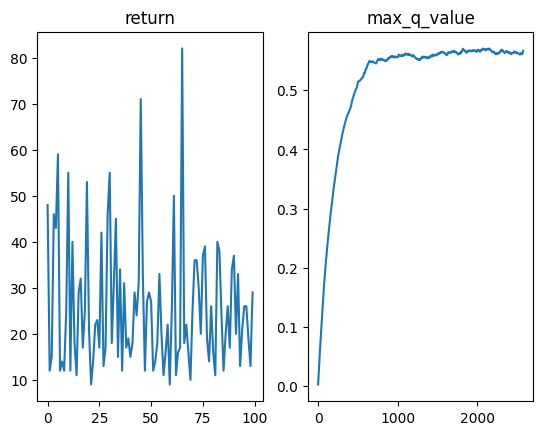

In [28]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
 
# 模型参数设置
n_hiddens = 16  # 隐含层个数
learning_rate = 2e-3  # 学习率
gamma = 0.9  # 折扣因子
return_list = []  # 保存每回合的reward
max_q_value = 0  # 初始的动作价值函数
max_q_value_list = []  # 保存每一step的动作价值函数
 
# 加载环境
# 连续性动作
env = gym.make("CartPole-v1", render_mode="human")
n_states = env.observation_space.shape[0]  # 状态数 4
n_actions = env.action_space.n  # 动作数 2
 
# 模型实例化
agent = PolicyGradient(n_states=n_states,  # 4
                       n_hiddens=n_hiddens,  # 16
                       n_actions=n_actions,  # 2
                       learning_rate=learning_rate,  # 学习率
                       gamma=gamma)  # 折扣因子
 
# 训练 
for i in range(100):  # 训练10回合
    # 记录每个回合的return
    episode_return = 0
    # 存放状态
    transition_dict = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [],
        'dones': [],
    }
    # 获取初始状态
    state = env.reset()[0]
    # 结束的标记
    done = False
 
    # 开始迭代
    while not done:
        # 动作选择
        action = agent.take_action(state)  # 对某一状态采取动作
        # 动作价值函数，曲线平滑
        max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
        # 保存每一step的动作价值函数
        max_q_value_list.append(max_q_value)
        # 环境更新
        next_state, reward, done, _, _ = env.step(action)
        # 保存每个回合的所有信息
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict['dones'].append(done)
        # 状态更新
        state = next_state
        # 记录每个回合的return
        episode_return += reward
 
    # 保存每个回合的return
    return_list.append(episode_return)
    # 一整个回合走完了再训练模型
    agent.learn(transition_dict)
 
    # 打印回合信息
    print(f'iter:{i}, return:{np.mean(return_list[-10:])}')
 
# 关闭动画
env.close()
        
# -------------------------------------- #
# 绘图
# -------------------------------------- #
 
plt.subplot(121)
plt.plot(return_list)
plt.title('return')
plt.subplot(122)
plt.plot(max_q_value_list)
plt.title('max_q_value')
plt.show()

In [4]:
import torch

A = torch.arange(6).reshape(3, 2)
print(A)
index = torch.randint(0,2,(3,2))
print(index)

tensor([[0, 1],
        [2, 3],
        [4, 5]])
tensor([[0, 1],
        [1, 1],
        [0, 0]])


In [6]:
A.gather(dim=1, index=index)

tensor([[0, 1],
        [3, 3],
        [4, 4]])

In [26]:
import torch.nn.functional as F
x = torch.tensor([[1.,2.],[1,1]])
F.softmax(x, dim=1)

tensor([[0.2689, 0.7311],
        [0.5000, 0.5000]])

In [24]:
x.shape

torch.Size([2, 2])